![ads2_0701.png](attachment:ads2_0701.png)

Now that we have interactive reports exposing different aspects of our data, we’re ready to make our first prediction. This forms our fourth agile sprint.

When making predictions, we take what we know about the past and use it to infer what will happen in the future. In doing so, we transition from batch processing of historical data to real-time extrapolation about the future. In real terms, our task in this chapter is to take historical flight records and use them to predict things about future flights.

In [1]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


## The Role of Predictions

We are all used to predictions in life. Some forecasts are based on statistical inference, and some are simply the opinions of pundits. Statistical inference is increasingly involved in predictions of all kinds. From weather forecasts to insurance actuaries determining rates to the point spread in sports betting or odds in poker, statistical predictions are a part of modern life. Sometimes forecasts are accurate, and sometimes they are inaccurate.

For instance, as I was working on this edition of the book, pundits repeatedly dismissed Donald Trump’s presidential candidacy as a joke, even as he gained on, pulled ahead of, and ultimately defeated all opponents in the primary and edged closer to Hillary Clinton as the election approached. Pundits are usually wrong, but accurate predictions in elections have emerged thanks to Nate Silver of FiveThirtyEight. He uses an advanced statistical model called a 538 regression to predict election results state-by-state, and combines these predictions into a model that was highly accurate in 2008 and 2012 (although, as it turns out, Silver—along with every rational member of the world with faith in the American voter—failed to predict Trump’s election... to be fair, though, he did predict a 29% chance for Trump, which was about double what others predicted).

We’ll be making predictions using statistical inference through a technique called machine learning. According to TechTarget, machine learning (ML for short) is “a type of artificial intelligence (AI) that provides computers with the ability to learn without being explicitly programmed.” Another way of explaining it is to say that machine learning handles tasks that would be impossibly complex for humans to program manually themselves.

Machine learning is an intimidating topic, an advanced field of study. Mastering all aspects of it can take many years. However, in practice, getting started with machine learning is easy, thanks to some of the libraries we’ll be using in this chapter. Once we explain the fundamentals, we’ll get on with some simple code.

## Predict What?

In this chapter we will employ machine learning to build a predictive analytics application using the dataset we’ve been visualizing so far. The prediction we’ll be making is one with great practical importance for anyone who travels by air. We’ll be predicting flight delays. Specifically, we’ll be predicting the arrival delay, or how late a flight is when arriving at the gate at its destination airport.

First, let’s cover the fundamentals of predictive analytics.

## Introduction to Predictive Analytics

According to Wikipedia “Predictive analytics encompasses a variety of statistical techniques from predictive modeling, machine learning, and data mining that analyze current and historical facts to make predictions about future or otherwise unknown events.”

Predictive analytics requires training data. Training data is composed of examples of the entity we are trying to predict. Examples are made up of one or more features. Dependent features are the values we are trying to predict. Independent features are features describing the things we want to predict that relate to the dependent features. For instance, our training data for predicting flight delays is our atomic records: our flight delay records. A flight with its delay is an example of a record with a dependent variable. Our independent features are other things we can associate with flights—in other words, all the entities and their properties we’ve been working with in the preceding chapters! The independent features are the other properties of flights—things like the departure delay, the airline, the origin and destination cities, the day of the week or year, etc.

We’ve been analyzing our data to better understand the features that make up a flight. We know a lot about flight delays, and about flights themselves and those things that combine to produce a flight: airplanes, airlines, airports, etc. This will enable us to effectively engage in feature engineering, which is the critical part of making predictions. Interactive visualization and exploratory data analysis as a part of feature engineering is the heart of Agile Data Science. It drives and organizes our efforts.

Now that the groundwork is laid, let’s learn the mechanics of making actual predictions.

### Making Predictions

There are two ways to approach most predictions: regression and classification. A regression takes examples made up of features as input and produces a numeric output. Classification takes examples as input and produces a categorical classification. The example dataset that serves as input to a statistical prediction and that enables the machine to learn is called the training data.

Whether to build a regression or a classification depends on our business need. The type of response variable often determines which to build. If we need to predict a continuous variable, we build a regression. If we need to predict a nominal/categorical variable, we build a classification.

This decision can be more complex than that, however, taking into account the user interface where we’ll present our prediction. For instance, if we were creating an API we were going to sell access to that predicts flight delays, we would probably want to use a regression to produce a numeric prediction. On the other hand, if we were presenting flight delays to users in a mobile application, usability considerations apply that might mean a classification might be better.

In this book, we’ll create both a regression and a classification of flight delays using decision trees, which can both classify and regress.

#### Features

A feature is what it sounds like: a feature of an example. In software terminology: if examples are objects, features are fields or properties of those objects. Two or more features make up the training data of a statistical prediction—two being the minimum because one field is required as the one to predict, and at least one additional feature is required to make an inference about in order to create a prediction.

Sometimes features are already a part of the training data in question, in their own fields. Sometimes we have to perform feature engineering to derive the training values we need from the ones the data includes.

The models we’ll be using employ decision trees. Decision trees are important for a few reasons. First, they can both classify and regress. It requires literally one line of code to switch between the two models just described, from a classification to a regression. Second, they are able to determine and share the feature importance of a given training set.

Feature importances tell us which features in the training data were most important in creating an accurate model. This is invaluable, because it gives us insight into what features we should engineer and the approach we should take to improving performance. It also gives us insight into the underlying data, by telling us which features have relationships with the predicted feature.

#### Regression

The simplest kind of regression analysis is a linear regression. Stat Trek defines linear regression as follows:

In a cause and effect relationship, the independent variable is the cause, and the dependent variable is the effect. Least squares linear regression is a method for predicting the value of a dependent variable Y, based on the value of an independent variable X.

A linear regression is a trend line. We’ve all seen them in Excel (if you haven’t, check out North Carolina State University’s Excel regression tutorial). Given a set of variables that characterize a flight, a linear regression might predict how early or late the flight will be, in minutes.

#### Classification

The second way to solve the problem is to define a set of categories and to classify a flight into one of those categories. Flight delays are a continuous distribution, so they don’t naturally yield to classification. The trick here is to define the categories so they simplify the continuous distribution of flight delays into two or more categories. For instance, we might formulate categories similar to the buckets we will use for the weather delay distribution (0–15, 15–60, and 60+), and then classify into these three categories.

## Exploring Flight Delays

Our topic for this chapter is flight delays. If we want to predict the feature, we must first understand it. Let’s lay the groundwork by creating a delay entity in our application and fleshing it out.

We’ll begin by exploring the magnitude of the problem. Just how often are flights late? It feels like “all the time,” but is it? This dataset is exciting in that it can answer questions like this one! 

Check out [ch07/explore_delays.py](ch07/explore_delays.py):

In [2]:
# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")
total_flights = on_time_dataframe.count()

# Flights that were late leaving...
late_departures = on_time_dataframe.filter(on_time_dataframe.DepDelayMinutes > 0)
total_late_departures = late_departures.count()

# Flights that were late arriving...
late_arrivals = on_time_dataframe.filter(on_time_dataframe.ArrDelayMinutes > 0)
total_late_arrivals = late_arrivals.count()

# Flights that left late but made up time to arrive on time...
on_time_heros = on_time_dataframe.filter(
  (on_time_dataframe.DepDelayMinutes > 0) 
  & 
  (on_time_dataframe.ArrDelayMinutes <= 0)
)
total_on_time_heros = on_time_heros.count()

# Get the percentage of flights that are late, rounded to 1 decimal place
pct_late = round((total_late_arrivals / (total_flights * 1.0)) * 100, 1)

print("Total flights:   {:,}".format(total_flights))
print("Late departures: {:,}".format(total_late_departures))
print("Late arrivals:   {:,}".format(total_late_arrivals))
print("Recoveries:      {:,}".format(total_on_time_heros))
print("Percentage Late: {}%".format(pct_late))

Total flights:   5,819,079
Late departures: 2,125,618
Late arrivals:   2,086,896
Recoveries:      606,902
Percentage Late: 35.9%


Wow, flights arrive late 35.9% of the time! The problem is as big as it seems. But how late is the average flight?

In [3]:
# Get the average minutes late departing and arriving
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
"""
).show()

+-----------+-----------+
|AvgDepDelay|AvgArrDelay|
+-----------+-----------+
|        9.4|        4.4|
+-----------+-----------+



Flights are 9.4 minutes late departing and 4.4 minutes late arriving on average. Why the constant tardiness? Are the airlines incompetent (as we often angrily suspect), or is the problem weather? Weather is presently out of human control, so that would let the airlines off the hook. Should we be mad at the airlines or angry with the god(s)? (Personally, I’m fearful of Zeus!)

Let’s take a look at some delayed flights, and specifically the fields that specify the kinds of delay. We want to be sure to use a random sample, which we can obtain via Spark’s DataFrame.sample function. In the first rendition of this chapter, I did not use a random sample and was deceived by what appeared to be constant weather delays, when these are actually not very common. Don’t be lazy—it’s very easy to insert a .sample(False, 0.01) before every one of your .show functions:

In [4]:
late_flights = spark.sql("""
SELECT
  FlightDate,
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")

late_flights.sample(False, 0.01).show(10)

+----------+---------------+------------+------------+--------+-------------+-----------------+
|FlightDate|ArrDelayMinutes|WeatherDelay|CarrierDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----------+---------------+------------+------------+--------+-------------+-----------------+
|2015-01-01|           21.0|         0.0|         0.0|    21.0|          0.0|              0.0|
|2015-01-01|           55.0|         8.0|         0.0|    16.0|          0.0|             31.0|
|2015-01-01|           54.0|         0.0|        32.0|    22.0|          0.0|              0.0|
|2015-01-01|           34.0|         0.0|         0.0|     5.0|          0.0|             29.0|
|2015-01-01|           18.0|         0.0|        18.0|     0.0|          0.0|              0.0|
|2015-01-01|           27.0|         0.0|         0.0|    27.0|          0.0|              0.0|
|2015-01-01|           23.0|         0.0|        23.0|     0.0|          0.0|              0.0|
|2015-01-01|           59.0|         0.0

An explanation of the different kinds of delay is available on the Federal Aviation Administration (FAA) website.

What does this small sample tell us? Carrier delays are constant and sometimes severe. NAS delays—delays under the control of the National Airspace System (NAS) that can be attributed to conditions such as traffic volume and air traffic control—are as common as carrier delays. Security delays appear rare, while late aircraft delays (which result from the propagation of a previous delay) are frequent and sometimes severe.

A small sample is a good way to get familiar with the data, but small samples can be deceptive. We want real answers we can trust, so let’s quantify the sources of delay. What percentage of total delay does each source contribute? We’ll use arrival delay for our total—a simplification we’ll have to live with, since some delay may be on departure and some in flight:

In [5]:
# Calculate the percentage contribution to delay for each source
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS 
     pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

+-----------------+-----------------+-------------+------------------+-----------------------+
|pct_weather_delay|pct_carrier_delay|pct_nas_delay|pct_security_delay|pct_late_aircraft_delay|
+-----------------+-----------------+-------------+------------------+-----------------------+
|              4.5|             29.2|         20.7|               0.1|                   36.1|
+-----------------+-----------------+-------------+------------------+-----------------------+



Our result isn’t perfect—the sources of delay don’t total to 100%. This is a result of our aforementioned simplification regarding arrival/departing delays. Nevertheless, we do get a sense of things; our sample is informative. Most delay is from previous delays with the same airplane, which have a cascading effect on the rest of the schedule. Of delays originating during a flight’s operations, most are carrier delays. Specifically, 29% of delays are carrier delays, versus 21% for air traffic control delays and only 4.5% for weather delays.

The answer to our earlier question is clear: we should usually be mad at the airline. However, not all carrier delays are because of mistakes the carrier makes. The FAA website explains:

_Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays._

In other words, sometimes shit happens and the carrier didn’t do anything wrong. We don’t have data to determine how often the carrier is really to blame. Importantly for our problem in this chapter, predicting flight delays, the best we’ll be able to do is to characterize the overall carrier delay of each airline. We won’t be modeling bird strikes or unruly passengers.

Having familiarized ourselves with flight delays, now let’s plug some of the features we’ve discovered into a simple classification and regression.

## Extracting Features with PySpark

To use features, we need to extract them from the broader dataset. Let’s begin by extracting just a few features from our dataset using PySpark, along with the time delays themselves. In order to do this, we need to decide which feature we’re going to predict. There are two delay fields listed in minutes: ArrDelayMinutes and DepDelayMinutes. Which are we to predict?

In thinking about our use case, it seems that our users want to know both things: whether and how late a flight will depart, and whether and how late it will arrive. Let’s include both in our training data. In terms of other features to extract, a little thought tells me that a few things are certain to matter. For instance, some airports have more delays than others, so departing and arriving airport is a no brainer. Flights are probably more often delayed in the hurricane and snow seasons, so the month of the year makes sense. Some carriers are more punctual than others. Finally, some routes must have more delays than others, so the flight number makes sense too.

We’ll also include the last of the unique identifiers for the flight, the flight date. Flights are uniquely identified by FlightDate, Carrier, FlightNum, and Origin and Dest. Always include all of the fields that uniquely identify a record, as it makes debugging easier.

That is all the features we will start with. The more features you use, the more complex wrangling them can get, so keep it simple and use just a few features at first. Once you have a pipeline set up with sklearn where you can iterate quickly and determine what helps and what doesn’t, you can add more.

All these features are simple and tabular, so it is easy to select them and store them as JSON for our model to read.

Let’s pick out and check our features. Check out [ch07/extract_features.py](extract_features.py):

In [6]:
import sys, os, re
import iso8601
import datetime

# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")

on_time_dataframe = on_time_dataframe.filter(on_time_dataframe.Month == '1')

# Select a few features of interest
simple_on_time_features = spark.sql("""
SELECT
  FlightNum,
  FlightDate,
  DayOfWeek,
  DayofMonth AS DayOfMonth,
  CONCAT(Month, '-',  DayofMonth) AS DayOfYear,
  Carrier,
  Origin,
  Dest,
  Distance,
  DepDelay,
  ArrDelay,
  CRSDepTime,
  CRSArrTime
FROM on_time_performance
  WHERE FlightDate < '2015-02-01'
""")
simple_on_time_features.show(5)

+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
|FlightNum|FlightDate|DayOfWeek|DayOfMonth|DayOfYear|Carrier|Origin|Dest|Distance|DepDelay|ArrDelay|CRSDepTime|CRSArrTime|
+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
|     1519|2015-01-01|        4|         1|      1-1|     AA|   DFW| MEM|   432.0|    -3.0|    -6.0|      1345|      1510|
|     1519|2015-01-01|        4|         1|      1-1|     AA|   MEM| DFW|   432.0|    -4.0|    -9.0|      1550|      1730|
|     2349|2015-01-01|        4|         1|      1-1|     AA|   ORD| DFW|   802.0|     0.0|    26.0|      1845|      2115|
|     1298|2015-01-01|        4|         1|      1-1|     AA|   DFW| ATL|   731.0|   100.0|   112.0|      1820|      2120|
|     1422|2015-01-01|        4|         1|      1-1|     AA|   DFW| HDN|   769.0|    78.0|    78.0|      0800|      0925|
+---------+-----

Looks like a few flights don’t have delay information. Let’s filter those, and sort the data before saving it as a single JSON file:

In [7]:
# Filter nulls, they can't help us
filled_on_time_features = simple_on_time_features.filter(
  simple_on_time_features.ArrDelay.isNotNull()
  &
  simple_on_time_features.DepDelay.isNotNull()
)

### DateTime Conversion

Now we need to convert all our dates and times (datetimes) from a string representation to a mathematical one—otherwise, our predictive algorithms can’t understand them in their proper and most useful contexts. To do so, we need some utility functions:

In [8]:
# We need to turn timestamps into timestamps, and not strings or numbers
def convert_hours(hours_minutes):
  hours = hours_minutes[:-2]
  minutes = hours_minutes[-2:]
  
  if hours == '24':
    hours = '23'
    minutes = '59'
  
  time_string = "{}:{}:00Z".format(hours, minutes)
  return time_string

In [9]:
def compose_datetime(iso_date, time_string):
  return "{} {}".format(iso_date, time_string)

In [10]:
def create_iso_string(iso_date, hours_minutes):
  time_string = convert_hours(hours_minutes)
  full_datetime = compose_datetime(iso_date, time_string)
  return full_datetime

In [11]:
def create_datetime(iso_string):
  return iso8601.parse_date(iso_string)

In [12]:
def convert_datetime(iso_date, hours_minutes):
  iso_string = create_iso_string(iso_date, hours_minutes)
  dt = create_datetime(iso_string)
  return dt

In [13]:
def day_of_year(iso_date_string):
  dt = iso8601.parse_date(iso_date_string)
  doy = dt.timetuple().tm_yday
  return doy

In [14]:
def alter_feature_datetimes(row):
  flight_date = iso8601.parse_date(row['FlightDate'])
  scheduled_dep_time = convert_datetime(row['FlightDate'], row['CRSDepTime'])
  scheduled_arr_time = convert_datetime(row['FlightDate'], row['CRSArrTime'])

  # Handle overnight flights
  if scheduled_arr_time < scheduled_dep_time:
    scheduled_arr_time += datetime.timedelta(days=1)

  doy = day_of_year(row['FlightDate'])
  
  return {
    'FlightNum': row['FlightNum'],
    'FlightDate': flight_date,
    'DayOfWeek': int(row['DayOfWeek']),
    'DayOfMonth': int(row['DayOfMonth']),
    'DayOfYear': doy,
    'Carrier': row['Carrier'],
    'Origin': row['Origin'],
    'Dest': row['Dest'],
    'Distance': row['Distance'],
    'DepDelay': row['DepDelay'],
    'ArrDelay': row['ArrDelay'],
    'CRSDepTime': scheduled_dep_time,
    'CRSArrTime': scheduled_arr_time,
  }

In practice, these functions were worked out iteratively over the course of an hour. Employing them is then simple:

In [15]:
timestamp_features = filled_on_time_features.rdd.map(alter_feature_datetimes)
timestamp_df = timestamp_features.toDF()

/home/ubuntu/spark/python/pyspark/sql/session.py:356: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


Always explicitly sort your data before vectorizing it. Don’t leave the sort up to the system. If you do so, a software version change or some other unknown cause might ultimately change the sort order of your training data as compared with your result data. This would be catastrophic and confusing and should be avoided at all costs. Explicitly sorting training data in a way that avoids arbitrary sorting is essential:

In [16]:
# Explicitly sort the data and keep it sorted throughout. 
# Leave nothing to chance.
sorted_features = timestamp_df.sort(
  timestamp_df.DayOfYear,
  timestamp_df.Carrier,
  timestamp_df.Origin,
  timestamp_df.Dest,
  timestamp_df.FlightNum,
  timestamp_df.CRSDepTime,
  timestamp_df.CRSArrTime,
)

Let’s copy the file into a JSON Lines file and check it out:

In [17]:
# Store as a single JSON file and bzip2 it
sorted_features.write.mode("overwrite").json("../data/simple_flight_delay_features.json")

Now take a look at the result:

In [19]:
%%bash
du -sh ../data/simple_flight_delay_features.json*
echo ""
head -5 ../data/simple_flight_delay_features.json/part-0000*

123M	../data/simple_flight_delay_features.json
3.0G	../data/simple_flight_delay_features.jsonl
56M	../data/simple_flight_delay_features.jsonl.bz2

==> ../data/simple_flight_delay_features.json/part-00000-b813b626-d1d6-43a3-9a1c-60d17b468124-c000.json <==
{"ArrDelay":13.0,"CRSArrTime":"2015-01-01T18:10:00.000Z","CRSDepTime":"2015-01-01T15:30:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":14.0,"Dest":"DFW","Distance":569.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"1024","Origin":"ABQ"}
{"ArrDelay":17.0,"CRSArrTime":"2015-01-01T10:15:00.000Z","CRSDepTime":"2015-01-01T07:25:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":14.0,"Dest":"DFW","Distance":569.0,"FlightDate":"2015-01-01T00:00:00.000Z","FlightNum":"1184","Origin":"ABQ"}
{"ArrDelay":36.0,"CRSArrTime":"2015-01-01T11:45:00.000Z","CRSDepTime":"2015-01-01T09:00:00.000Z","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":-2.0,"Dest":"DFW","Distance

Looking good! Our features are now prepared for vectorization.

## Building a Classifier with Spark MLlib

As we saw in our last example, in order to use sklearn to classify or regress all 5.4 million usable flight on-time performance records for 2015, we had to sample down to 1 million records. There simply isn’t enough RAM on one typical machine to train the model on all the training data. This is where Spark MLlib comes in. From the Machine Learning Library (MLlib) Guide:

_Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:_

* ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering

* Featurization: feature extraction, transformation, dimensionality reduction, and selection

* Pipelines: tools for constructing, evaluating, and tuning ML Pipelines

* Persistence: saving and load algorithms, models, and Pipelines

* Utilities: linear algebra, statistics, data handling, etc.

MLlib uses Spark DataFrames as the foundation for tables and records. Although some RDD-based methods still remain, they are not under active development.

Note that we are using Spark MLlib because it can work across many machines to handle large volumes of data. We’re only using one machine in this book’s examples, but the code and the process are identical regardless of the size of the cluster. By learning to build a predictive model with Spark MLlib on a single machine, you are learning to operate a cluster of 1,000 machines. Services like Amazon Elastic MapReduce make booting a working Spark cluster a matter of point-and-click. We covered doing analytics in the cloud in the first edition, but removed that chapter to make room for other content in this edition.

Now, follow along as we build a classifier using PySpark and Spark MLlib in [ch07/train_spark_mllib_model.py](train_spark_mllib_model.py).

### Loading Our Training Data with a Specified Schema

First we must load our training data back into Spark. When we first loaded our data, Spark SQL had trouble detecting our timestamp and date types, so we must specify a schema for Spark to go on (just like in our sklearn model, it is important for our training data to be typed correctly for it to be interpreted for statistical inference):

In [20]:
#
# {
#   "ArrDelay":5.0,"CRSArrTime":"2015-12-31T03:20:00.000-08:00",
#   "CRSDepTime":"2015-12-31T03:05:00.000-08:00",
#   "Carrier":"WN","DayOfMonth":31,"DayOfWeek":4,
#   "DayOfYear":365,"DepDelay":14.0,"Dest":"SAN",
#   "Distance":368.0, "FlightDate":"2015-12-30T16:00:00.000-08:00",
#   "FlightNum":"6109","Origin":"TUS"
# }
#

from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, TimestampType 
from pyspark.sql.types import StructType, StructField

schema = StructType([
  StructField("ArrDelay", FloatType(), True),       # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True), # "CRSArrTime":"2015-12..."
  StructField("CRSDepTime", TimestampType(), True), # "CRSDepTime":"2015-12..."
  StructField("Carrier", StringType(), True),       # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True),   # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),    # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),    # "DayOfYear":365
  StructField("DepDelay", FloatType(), True),       # "DepDelay":14.0
  StructField("Dest", StringType(), True),          # "Dest":"SAN"
  StructField("Distance", FloatType(), True),       # "Distance":368.0
  StructField("FlightDate", DateType(), True),      # "FlightDate":"2015-12..."
  StructField("FlightNum", StringType(), True),     # "FlightNum":"6109"
  StructField("Origin", StringType(), True),        # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.json", 
  schema=schema
)
features.first()

Row(ArrDelay=-14.0, CRSArrTime=datetime.datetime(2015, 1, 18, 15, 19), CRSDepTime=datetime.datetime(2015, 1, 18, 13, 35), Carrier='B6', DayOfMonth=18, DayOfWeek=7, DayOfYear=18, DepDelay=-5.0, Dest='DCA', Distance=634.0, FlightDate=datetime.date(2015, 1, 18), FlightNum='716', Origin='JAX')

With our data loaded, now we need to prepare our data for classification.

### Addressing Nulls

Before we can use the tools that PySpark’s MLlib provides us, we must eliminate null values from fields in rows of our DataFrames. Otherwise our code will crash as we start to employ tools from `pyspark.ml.features`.

To detect null values in columns, we need only loop through our columns and inspect them with `pyspark.sql.Column.isNull`:

In [21]:
null_counts = [(column, features.where(features[column].isNull()).count()) \
  for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

[]


If null values are found, we need only employ `DataFrame.na.fill` to fill them. Supply `fillna` with a dict with the column name as the key and the column’s fill value as the value, and it will fill in the column name with that value:

In [21]:
#filled_features = features.na.fill({'column_name': 'missing_replacement_value'})

In our dataset, no nulls are found, but there usually are some, so take note of this step for the future. It will save you trouble as you start engineering and vectorizing your features.

### Replacing FlightNum with Route

At this point it occurs to us that `FlightNums` will change, but routes do not… so long as we define a route as a pair of cities. So, let’s add a column Route, which is defined as the concatenation of `Origin`, -, and `Dest`, such as `ATL-SFO`. This will very simply inform our model whether certain routes are frequently delayed, separately from whether certain airports tend to have delays for inbound or outbound flights.

To add Route, we need to use two utilities from the pyspark.sql.functions package. The concat function concatenates multiple strings together, and the lit function is needed to specify a literal string to concatenate:

In [22]:
#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat
features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

+------+----+-------+
|Origin|Dest|  Route|
+------+----+-------+
|   JAX| DCA|JAX-DCA|
|   JAX| FLL|JAX-FLL|
|   JAX| FLL|JAX-FLL|
|   JAX| JFK|JAX-JFK|
|   JAX| JFK|JAX-JFK|
+------+----+-------+
only showing top 5 rows



### RDD Alternative RouteNum

Note that if we wanted to, we could convert the record to an RDD, where we could run something like the following:

```python
def add_route(record):
  record = record.asDict()
  record['Route'] = record['Origin'] + "-" + record['Dest']
  return record

features_with_route_rdd = features.rdd.map(add_route)
```

The reason to use DataFrames is that they are much, much faster than RDDs, even if the API is slightly more complex.

### Bucketizing a Continuous Variable for Classification

Classification does not work to predict a continuous variable like flight delays (in minutes); classifications predict two or more categories. Therefore, in order to build a classifier for flight delays, we have to create categories our of delays in minutes.

#### Determining Arrival Delay Buckets

In the first run-through writing the book, we used the same buckets as Bay Area startup FlightCaster (founded in 2009 and acquired in 2011 by Next Jump): on time, slightly late, and very late. The values corresponding to these bins come from a natural split in how people think about time in terms of minutes, hours, and days. One hour is an intuitive value for the high end of slightly late. Over one hour would then be very late. “On time” would be within 15 minutes of the scheduled arrival time. If such natural bins weren’t available, you would want to closely analyze the distribution of your continuous variable to determine what buckets to use.

As it turned out, this analysis was necessary in our case too. When writing the book, while debugging an issue with our Spark ML classifier model, we did an analysis where we found that a different set of categories were needed. Check out the Jupyter notebook at ch09/Debugging Prediction Problems.ipynb for details. Note that GitHub supports the display of Jupyter notebooks, which makes them a really powerful way to share data analyses—just commit and push to a GitHub repository and you’ve got a shared report. When you are doing iterative visualization, notebooks are very handy.

#### Iterative Visualization with Histograms

To begin, check out the overall distribution of flight delays, which we compute by converting the features `DataFrame` to an `RDD` and then employing `RDD.histogram`. `RDD.histogram` returns two lists: a set of buckets, and the count for each bucket. We then use `matplotlib.pyplot` to create a histogram. Note that because our buckets are already counted, we can’t use `pyplot.hist`. Instead, we employ `pyplot.bar` to create a histogram from our precomputed buckets and their corresponding counts.

To gather our data, we select the `ArrDelay` column, convert the DataFrame to an `RDD`, and call `RDD.flatMap` to convert our records into an `RDD` containing a single list of floats:

In [25]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Look at overall histogram
data_tuple = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-87.0, -60, -30, -15, 0, 15, 30, 60, 120])
data_tuple

([-87.0, -60, -30, -15, 0, 15, 30, 60, 120],
 [58, 10079, 73462, 180178, 97285, 37543, 29913, 19260])

Next, we extract the heights of the bars and the bin definitions from the tuple returned by histogram:

In [26]:
heights = np.array(data_tuple[1])

# The bins are 1 > length than the values
full_bins = data_tuple[0]
full_bins

[-87.0, -60, -30, -15, 0, 15, 30, 60, 120]

Since bars are drawn from the left, we remove the rightmost item in the bins list:

In [27]:
# Bars are drawn from the left
mid_point_bins = full_bins[:-1]
mid_point_bins

[-87.0, -60, -30, -15, 0, 15, 30, 60]

Next, we use a list comprehension to determine the range between the values defining the buckets, which gives us the width of the bars. We’ve decided that the bars should be as wide as the data they measure:

In [28]:
# The width of a bar should be the range it maps in the data
widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
widths

[27.0, 30, 15, 15, 15, 15, 30, 60]

Finally, we plot the bar chart, specifying our bar widths (they draw from the left) and coloring our bars blue:

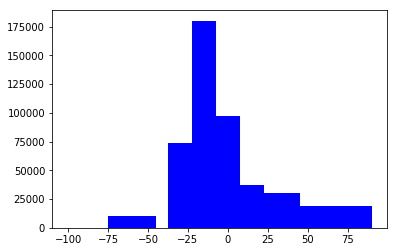

In [29]:
# And now the bars should plot nicely
bar = plt.bar(mid_point_bins, heights, width=widths, color='b')

We can summarize the previous operations in a function called create_hist, which we will reuse to draw other histograms like this one:

In [30]:
def create_hist(rdd_histogram_data):
  """Given an RDD.histogram, plot a pyplot histogram"""
  heights = np.array(rdd_histogram_data[1])
  full_bins = rdd_histogram_data[0]
  mid_point_bins = full_bins[:-1]
  widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
  bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
  return bar

To start, let’s visualize the first set of buckets we considered: –87 to 15, 15 to 60, and 60 to 200. Note that the first item in the bucket definition, –87, comes from the minimum delay in the dataset. We use 200 to keep from distorting the chart, although the maximum delay is actually 1,971 minutes:

<BarContainer object of 3 artists>

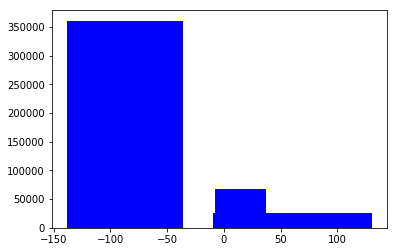

In [31]:
%matplotlib inline

buckets = [-87.0, 15, 60, 200]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

Wow. This is a very distorted distribution. We have created an imbalanced class set from one that should ideally be balanced. This is a problem, because imbalanced classes can produce classifiers that only predict the most common value, and yet still seem fairly accurate. At best, this label set would have made things hard for our classifier when there is no benefit to doing so. We need to rethink our labels.

Let’s try something a little more granular and check the distribution using the set of buckets: [-87.0, -30, -15, 0, 15, 30, 120]:

<BarContainer object of 6 artists>

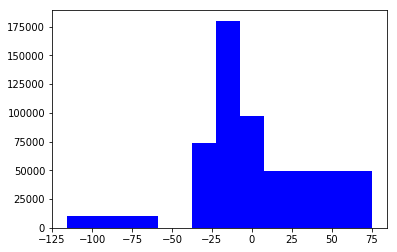

In [32]:
%matplotlib inline

buckets = [-87.0, -30, -15, 0, 15, 30, 120]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

Hmm... this looks better, but the leftmost and rightmost buckets look too small. Let’s combine the –87 to –30 and –30 to –15 buckets, and try again:

<BarContainer object of 5 artists>

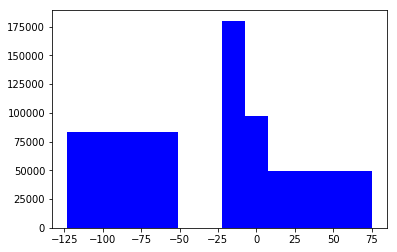

In [33]:
%matplotlib inline

buckets = [-87.0, -15, 0, 15, 30, 120]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

This looks better! However, the 15–30 bucket seems too small. Let’s merge this bucket with the 0–15 bucket and try again:

<BarContainer object of 4 artists>

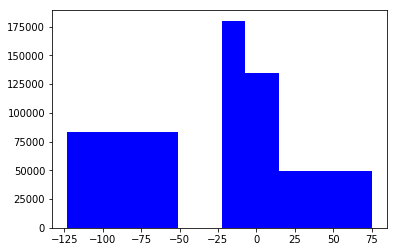

In [34]:
%matplotlib inline

buckets = [-87.0, -15, 0, 30, 120]
rdd_histogram_data = features\
  .select("ArrDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(buckets)

create_hist(rdd_histogram_data)

Ah-ha! That looks pretty good. The buckets end up being “very early” (> 15 minutes early), “early” (0–15 minutes early), “late” (0–30 minutes late), and “very late” (30+ minutes late). These aren’t perfect in terms of usability, but I think they can work. Ideally the distribution in the buckets would be equal, but they are close enough.

#### Bucket Quest Conclusion

We have now determined the right bucket scheme for converting a continuous variable, flight delays, into four categories. Note how we used a Jupyter notebook along with PySpark and PyPlot to iteratively visualize the flights that fell into each bucketing scheme. This notebook is now a shareable asset. This would serve as a great jumping-off point for a discussion involving the data scientist who created the notebook, the product manager for the product, and the engineers working on the project.

Now that we’ve got our buckets, let’s apply them and get on with our prediction!

### Bucketizing with a DataFrame UDF

We can bucketize our data in one of two ways: using a `DataFrame` UDF, or with `pyspark.ml.feature.Bucketizer`.

Let’s begin by using a UDF to categorize our data in accordance with the scheme in the preceding section. We’ll create a function, `bucketize_arr_delay`, to achieve the “bucketizing,” and then wrap it in a UDF along with a StructField of type information—in this case the string DataType `StringType`. Next, we’ll apply the UDF to create a new column via `DataFrame.withColumn`. Finally, we’ll select ArrDelay and ArrDelayBucket and see how they compare:

In [35]:
#
# Categorize or 'bucketize' the arrival delay field using a DataFrame UDF
#
def bucketize_arr_delay(arr_delay):
  bucket = None
  if arr_delay <= -15.0:
    bucket = 0.0
  elif arr_delay > -15.0 and arr_delay <= 0.0:
    bucket = 1.0
  elif arr_delay > 0.0 and arr_delay <= 30.0:
    bucket = 2.0
  elif arr_delay > 30.0:
    bucket = 3.0
  return bucket

# Wrap the function in pyspark.sql.functions.udf with
# pyspark.sql.types.StructField information
from pyspark.sql.functions import udf
dummy_function_udf = udf(bucketize_arr_delay, StringType())

# Add a category column via pyspark.sql.DataFrame.withColumn
manual_bucketized_features = features_with_route.withColumn(
  "ArrDelayBucket",
  dummy_function_udf(features['ArrDelay'])
)
manual_bucketized_features.select("ArrDelay", "ArrDelayBucket").show(10)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|   -14.0|           1.0|
|   -10.0|           1.0|
|    -9.0|           1.0|
|    36.0|           3.0|
|     7.0|           2.0|
|   -40.0|           0.0|
|    57.0|           3.0|
|   -33.0|           0.0|
|   -13.0|           1.0|
|    -6.0|           1.0|
+--------+--------------+
only showing top 10 rows



You can see that ArrDelay is mapped to ArrDelayBucket as we indicated.

### Bucketizing with `pyspark.ml.feature.Bucketizer`

Creating buckets for classification is simpler using Bucketizer. We simply define our splits in a list, instantiate our Bucketizer, and then apply a transformation on our features DataFrame. We’ll do this transformation for the ArrDelay field:

In [36]:
#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show(10)

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|   -14.0|           1.0|
|   -10.0|           1.0|
|    -9.0|           1.0|
|    36.0|           3.0|
|     7.0|           2.0|
|   -40.0|           0.0|
|    57.0|           3.0|
|   -33.0|           0.0|
|   -13.0|           1.0|
|    -6.0|           1.0|
+--------+--------------+
only showing top 10 rows



You can see the result is the same as with our UDF buckets. Now that we’ve created the `ArrDelayBucket` fields, we’re ready to vectorize our features using tools from `pyspark.ml.feature`.

## Feature Vectorization with `pyspark.ml.feature`

Spark MLlib has an extremely rich library of functions for various machine learning tasks, so it is helpful when using MLlib to have the API documentation open in a browser tab, along with the DataFrame API documentation. While an RDD-based API does exist, we’ll be using the DataFrame-based MLlib routines.

### Vectorizing Categorical Columns with Spark ML

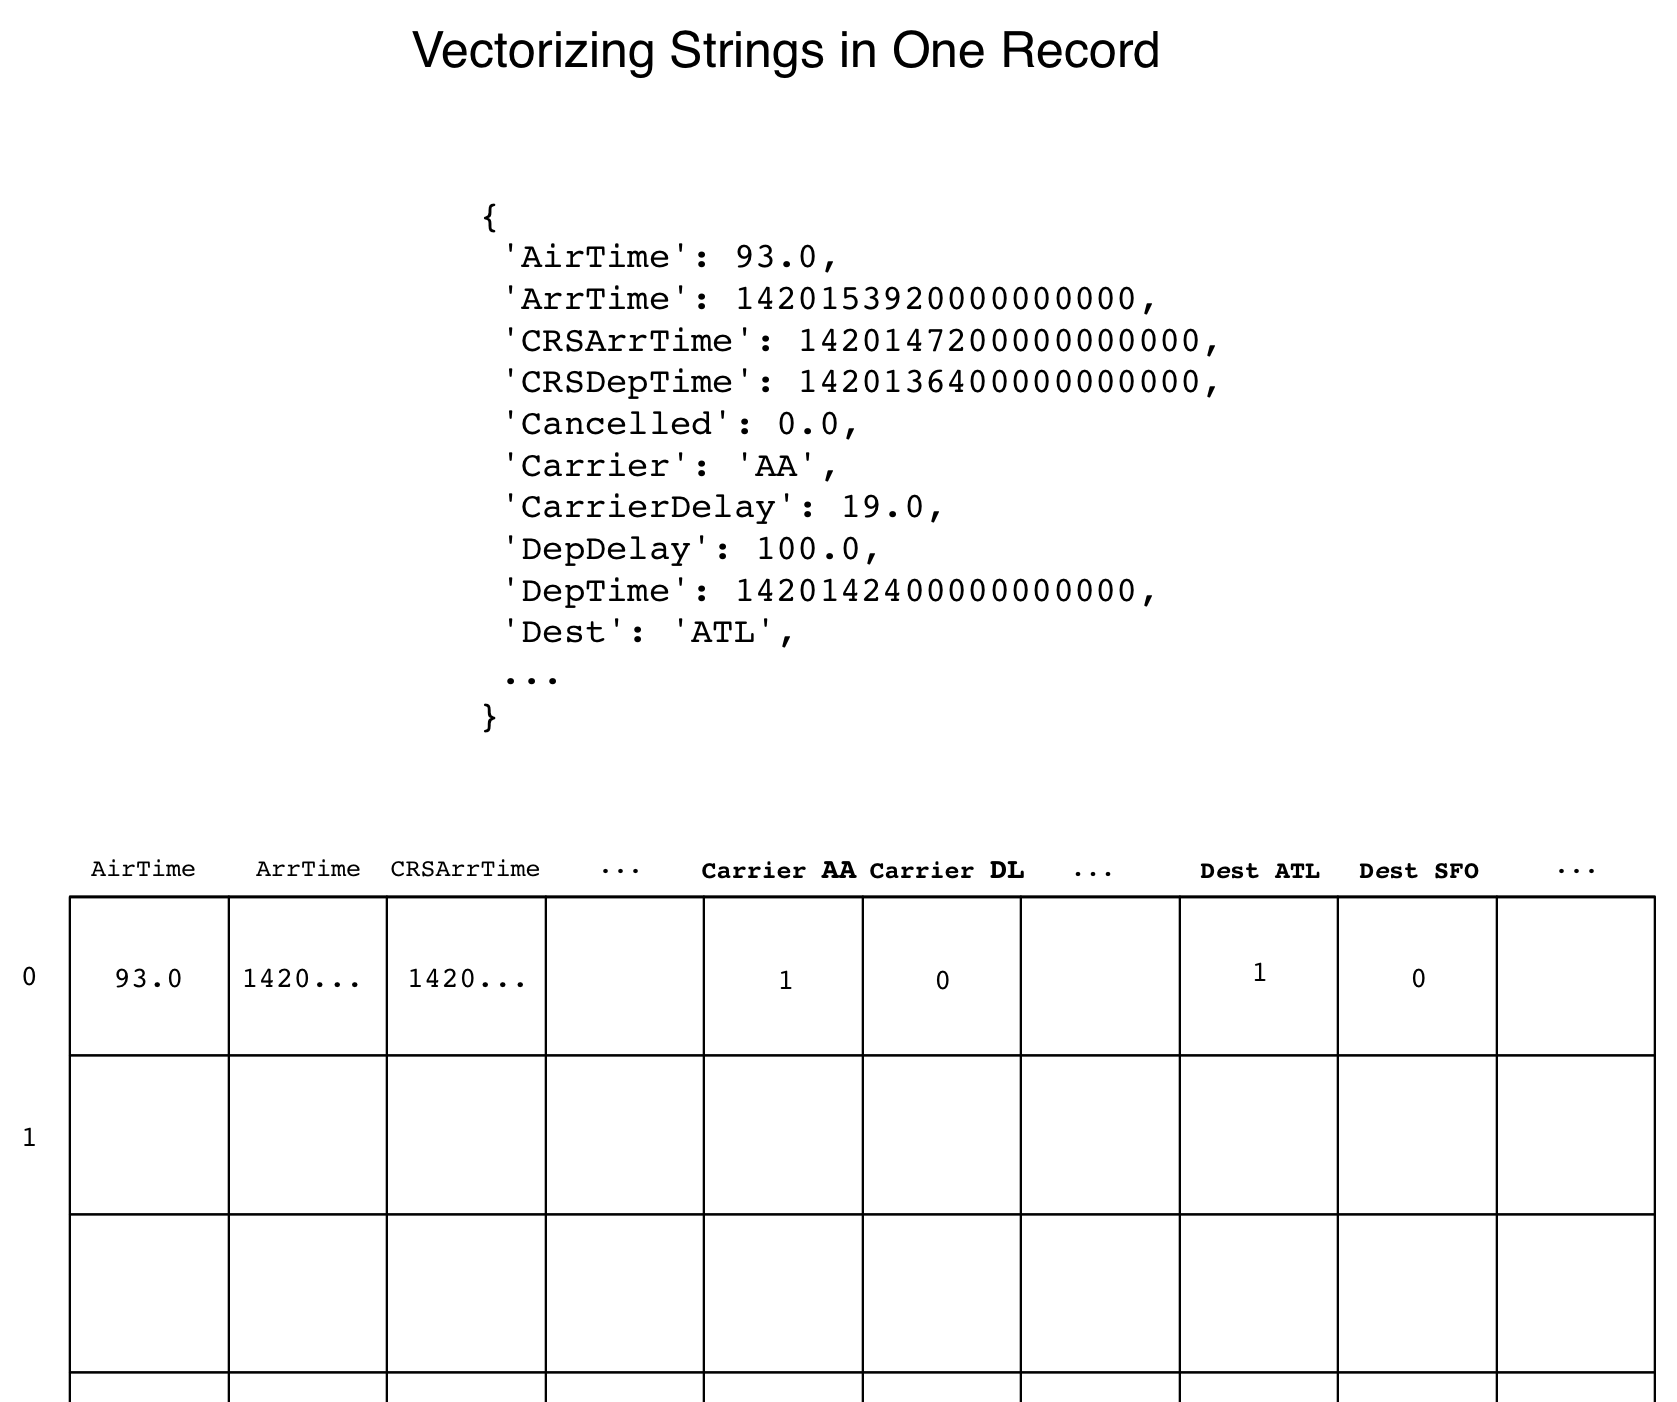

To follow along with this section, open the pyspark.ml.feature documentation. First we need to import our tools from pyspark.ml.feature:

In [37]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

Then we need to index our nominal or categorical string columns into sets of vectors made up of binary variables for every unique value found in a given column. To achieve this, for each categorical column (be it a string or number), we need to:

1. Configure and create a StringIndexer to index the column into one number per unique value.

2. Execute fit on the StringIndexer to get a StringIndexerModel.

3. Run the training data through StringIndexerModel.transform to index the strings into a new column.

The code to implement these steps for each categorical variable column looks like this:

In [38]:
# Turn category fields into categoric feature vectors, then drop 
# intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                         .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|   -14.0|2015-01-18 15:19:00|2015-01-18 13:35:00|     B6|        18|        7|       18|    -5.0| DCA|   634.0|2015-01-18|      716|   JAX|JAX-DCA|           1.0|          8.0|            24.0|            5.0| 

Having indexed our categorical features, now we combine them with our numeric features into a single feature vector for our classifier.

### Vectorizing Continuous Variables and Indexes with Spark ML

As they are already numeric, there isn’t much work required to vectorize our continuous numeric features. And now that we have indexes, we have a numeric representation of each string column. Now we simply employ VectorAssembler to combine the numeric and index columns into a single feature Vector. Then we drop the index columns, as they aren’t needed anymore:

In [39]:
# Handle continuous numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show(10)

final_vectorized_features = final_vectorized_features.filter(final_vectorized_features.FlightDate < '2015-02-01')

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|   -14.0|2015-01-18 15:19:00|2015-01-18 13:35:00|     B6|        18|        7|       18|    -5.0| DCA|   634.0|2015-01-18|      716|   JAX|JAX-DCA|           1.0|[-5.0,634.0,8.0,2...|
|   -10.0|2015-01-18 08:12:00|2015-01-18 07:00:00|     B6|        18|        7|       18|   -13.0| FLL|   319.0|2015-01-18|     1015|   JAX|JAX-FLL|           1.0|[-13.0,319.0,8.0,...|
|    -9.0|2015-01-18 19:52:00|2015-01-18 18:40:00|     B6|        18|      

Now we’re ready to train our classifier!

### Classification with Spark ML

Our features are prepared in a single field, Features_vec, and we’re ready to compose the experiment we’ll run as part of creating our classifier. To drive our experiment, we require a training dataset and a test dataset. As we discussed earlier, a training dataset is used to train the model and a test set is used to gauge its accuracy. Cross-validation ensures that the models we create in the lab perform well in the real world, and not just on paper.

#### Test/Train Split with DataFrames

As before with scikit-learn, we need to cross-validate. This means splitting our data between a training set and a test set.

The DataFrame API makes this easy with `DataFrame.randomSplit`. This takes an array featuring the ratios of the splits, which should add up to 1:

In [40]:
# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.8, 0.2])

### Creating and Fitting a Model

It takes three lines to import, instantiate, and fit a random forest classifier using our training dataset. Note that we’re using a random forest classifier because this is the most accurate decision tree model available in Spark MLlib that can classify into multiple categories. These classifiers also offer feature importances, which we will use in Chapter 9 to improve the model.

Also note that we run the model once, and it throws an exception because we have more than 32 unique values for one feature, the default value for maxBins. We set maxBins to the value suggested by the exception, 4657, and the model fits successfully. Note that this can take a while, so grab some coffee:

In [41]:
# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024
)
model = rfc.fit(training_data)

Next, we need to evaluate the classifier we’ve created.

### EVALUATING A MODEL

We can evaluate the performance of our classifier using the `MulticlassClassificationEvaluator`, which simply wraps the predictions we get from running `pyspark.ml.classification.RandomForestClassificationModel.transform` on the test dataset. Several metrics are available, but we’ll start with the raw accuracy:

In [42]:
# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
  labelCol="ArrDelayBucket", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.5892051180929845


Not great, but good enough for now. Don’t worry, we’ll work on making the model more accurate in Chapter 9.

Let’s lay eyes on some of the predictions, to see that they’re sane. At one point we had a bug where all predictions were 0.0. Seeing a sample with different prediction values takes a bit of cleverness because of the way the transformation sorts the data, so we order the sample by the reservation system departure time before displaying it:

In [43]:
# Sanity-check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|         CRSArrTime|         CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+-------------------+-------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|   -16.0|2015-01-01 09:48:00|2015-01-01 07:15:00|     B6|         1|        4|        1|   -11.0| HPN|   972.0|2015-01-01|      394|   MCO|MCO-HPN|           0.0|[-11.0,972.0,8.0,...|[4.01153450436008...|[0.20057672521800...|       1.0|
|    -7.0|2015-01-01 15:30:00|2015-01-01 12:30:0

Now let’s see the distribution of the Prediction field, to verify we don’t have that same bug:

In [44]:
predictions.groupBy("Prediction").count().show()

+----------+-----+
|Prediction|count|
+----------+-----+
|       0.0|  891|
|       1.0|62921|
|       3.0|10248|
|       2.0|17224|
+----------+-----+



This “sanity check” seems okay!

### Evaluation Conclusion

With Spark, we can create, train, and evaluate a classifier or regression in a few lines of code. Surprisingly, it is even more powerful than scikit-learn. But to be useful, we’ve got to deploy our prediction. We’ll do that in the next chapter.

Now we have a problem—how do we deploy Spark ML models? Unlike scikit-learn models, we can’t simply place them inside our web application as an API, because they require the Spark platform to run. This is something we will address in the next chapter.

## Exercises

1. Using the code above as a guide, create a model that predicts departure delay, `DepDelay`. Be sure not to use arrival delay, `ArrDelay` in your model :)

## Conclusion

In this chapter we’ve taken what we know about the past to predict the future.

In the next chapter, we’ll drill down into this prediction to drive a new action that can take advantage of it.